In [1]:
# imports
import csv
import numpy as np
import pandas as pd
import import_ipynb
import spacy
from sklearn.model_selection import train_test_split
from tqdm import tqdm

nlp = spacy.load(
    "de_core_news_lg", exclude=["tok2vec", "ner", "parser", "attribute_ruler"]
)
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import make_sampling_table, pad_sequences
from tensorflow.keras import Model, Sequential, Input
from tensorflow.keras.layers import (
    Dot,
    Embedding,
    Flatten,
    Dense,
    GlobalAveragePooling1D,
    LSTM,
    concatenate,
    Dropout,
    Bidirectional,
)
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
#data
data = pd.DataFrame(columns=['tweet', 'party'])

afd = pd.read_csv('../cleaned-data/AfD.csv', quoting=csv.QUOTE_NONE)['text']
afd = pd.DataFrame([[i, 0] for i in afd], columns=['tweet', 'party'])

data = data.append(afd, ignore_index=True)

cdu = pd.read_csv('../cleaned-data/CDU.csv',quoting=csv.QUOTE_NONE)['text']
csu = pd.read_csv('../cleaned-data/CSU.csv',quoting=csv.QUOTE_NONE)['text']

cdu = pd.DataFrame([[i, 1] for i in cdu], columns=['tweet', 'party'])
csu = pd.DataFrame([[i, 1] for i in csu], columns=['tweet', 'party'])

data = data.append(cdu, ignore_index=True)
data = data.append(csu, ignore_index=True)

fdp = pd.read_csv('../cleaned-data/FDP.csv',quoting=csv.QUOTE_NONE)['text']
fdp = pd.DataFrame([[i, 2] for i in fdp], columns=['tweet', 'party'])

data = data.append(fdp, ignore_index=True)

gru = pd.read_csv('../cleaned-data/GRÜNE.csv',quoting=csv.QUOTE_NONE)['text']
gru = pd.DataFrame([[i, 3] for i in gru], columns=['tweet', 'party'])

data = data.append(gru, ignore_index=True)

lin = pd.read_csv('../cleaned-data/LINKE.csv',quoting=csv.QUOTE_NONE)['text']
lin = pd.DataFrame([[i, 4] for i in lin], columns=['tweet', 'party'])

data = data.append(lin, ignore_index=True)

spd = pd.read_csv('../cleaned-data/SPD.csv',quoting=csv.QUOTE_NONE)['text']
spd = pd.DataFrame([[i, 5] for i in spd], columns=['tweet', 'party'])

data = data.append(spd, ignore_index=True)
data = data.dropna()

In [6]:
words = []
em_matrix = np.genfromtxt(fname = "../word_embedding/embeddings/vector_all_data_lemma_300d-3-5.tsv", delimiter = "\t" )       
with open("../vocab/all_lemma_vocab_token.csv", mode='r') as infile:
    reader = csv.reader(infile)
    next(reader) #skip header
    vocab = {rows[0]:int(rows[2]) for rows in reader}
vocab['UNK'] = len(vocab)

In [8]:
data['vectors'] = data['tweet'].apply([lambda x: [vocab[y.lemma_] if y.lemma_ in vocab else vocab['UNK'] for y in nlp(str(x))]])
data['len'] = data['vectors'].apply(lambda x: len(x))
data_len = data['len'].max()
data['vectors'] = data['vectors'].apply(lambda x: pad_sequences([x], maxlen=50, dtype=int, padding='post',value=0)[-1])
data['len'] = data['vectors'].apply(lambda x: len(x))
data_len = data['len'].max()
data

,tweet,party,vectors,len
0,Teenie auf dem Weg nach Malle Nein Aussenminis...,0,"[31205, 18, 1, 220, 56, 38565, 195, 1410, 18, ...",50
1,Heute Abend bin ich gemeinsam mit user zu Gast...,0,"[122, 372, 5, 3, 201, 16, 2, 12, 1162, 109, 52...",50
2,Berlin 17 Grad Die Frisur passt Unsere Motivat...,0,"[93, 938, 2390, 1, 8861, 819, 11, 5214, 17, 16...",50
3,Lieber user lieber user ich gratuliere Ihnen h...,0,"[612, 2, 165, 2, 3, 1996, 3, 637, 49, 1652, 82...",50
4,Seit gestern koennen die Mitglieder unserer Af...,0,"[125, 409, 91, 1, 358, 11, 35, 422, 1438, 185,...",50
...,...,...,...,...
306944,user Danke,5,"[2, 58, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",50
306945,Herzlich Willkommen in der SPD Seit gestern Ab...,5,"[3193, 2241, 6, 1, 86, 125, 409, 372, 5, 11070...",50
306946,Hatte 4 gute Jahre als Vors SPD BTF Freue mich...,5,"[13, 242, 34, 63, 26, 17124, 86, 64724, 652, 7...",50
306947,Glueckwunsch an Nils Annen,5,"[173, 22, 15830, 39290, 0, 0, 0, 0, 0, 0, 0, 0...",50


In [12]:
y = tf.keras.utils.to_categorical(data['party'].to_numpy())
y
X = np.array([np.array(x) for x in data['vectors']])
X

array([[31205,    18,     1, ...,     0,     0,     0],
       [  122,   372,     5, ...,     0,     0,     0],
       [   93,   938,  2390, ...,     0,     0,     0],
       ...,
       [   13,   242,    34, ...,     0,     0,     0],
       [  173,    22, 15830, ...,     0,     0,     0],
       [   28,    90,   615, ...,     0,     0,     0]])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.4)

In [105]:
# Deep learning: 
class RnnModel():

    def __init__(self, embedding_matrix, embedding_dim, max_len):
        
        inp1 = Input(shape=(max_len,))
        x = Embedding(embedding_matrix.shape[0], embedding_dim, weights=[embedding_matrix])(inp1)
        x = Bidirectional(LSTM(128, return_sequences=True))(x)
        x = Bidirectional(LSTM(64))(x)
        x = Dense(128, activation="relu")(x)
        x = Dropout(0.1)(x)
        x = Dense(64, activation="relu")(x)
        x = Dense(6, activation="softmax")(x)    
        model = Model(inputs=inp1, outputs=x)
        model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=["accuracy"])
        self.model = model


In [14]:
# Deep learning: 
class RnnModel2():

    def __init__(self, embedding_matrix, embedding_dim, max_len):
        
        inp1 = Input(shape=(max_len,))
        x = Embedding(embedding_matrix.shape[0], embedding_dim, weights=[embedding_matrix])(inp1)
        x = Bidirectional(LSTM(256, return_sequences=True))(x)
        x = Bidirectional(LSTM(128))(x)
        x = Dense(256, activation="relu")(x)
        x = Dropout(0.1)(x)
        x = Dense(64, activation="relu")(x)
        x = Dense(6, activation="softmax")(x)    
        model = Model(inputs=inp1, outputs=x)
        model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=["accuracy"])
        self.model = model

In [15]:
m2 = RnnModel2(em_matrix, 300, 50)
h2 = m2.model.fit(X_train, y_train, epochs = 5, batch_size = 512, verbose = 1, validation_data=(X_val, y_val))

Epoch 1/5
476/476 [==============================] - 1265s 3s/step - loss: 0.3928 - accuracy: 0.3711 - val_loss: 0.3477 - val_accuracy: 0.4667
Epoch 2/5
476/476 [==============================] - 1012s 2s/step - loss: 0.3133 - accuracy: 0.5390 - val_loss: 0.3148 - val_accuracy: 0.5355
Epoch 3/5
476/476 [==============================] - 1030s 2s/step - loss: 0.2662 - accuracy: 0.6217 - val_loss: 0.3091 - val_accuracy: 0.5556
Epoch 4/5
476/476 [==============================] - 1023s 2s/step - loss: 0.2304 - accuracy: 0.6773 - val_loss: 0.3255 - val_accuracy: 0.5637
Epoch 5/5
476/476 [==============================] - 960s 2s/step - loss: 0.1998 - accuracy: 0.7225 - val_loss: 0.3374 - val_accuracy: 0.5632


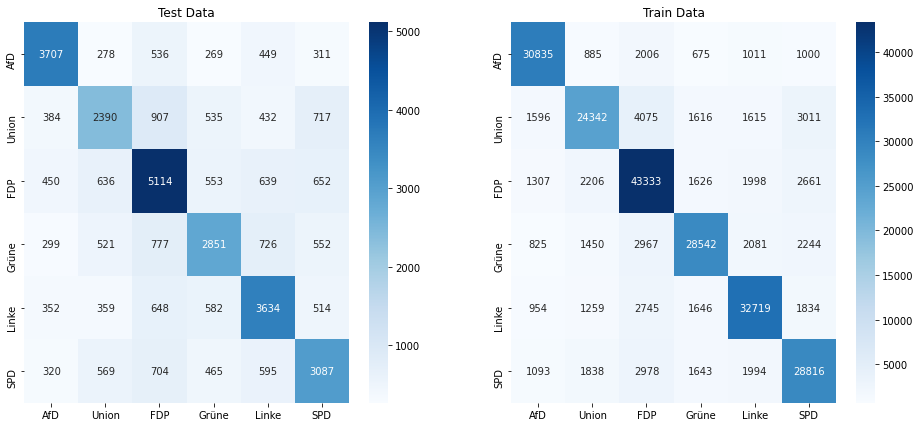

Party: 	 Test 	 Train
Afd:	 5550 	 36412
Union:	 5365 	 36255
FDP:	 8044 	 53131
Grüne:	 5726 	 38109
Linke:	 6089 	 41157
SPD:	 5740 	 38362

Acc:	 56.92% 77.47%


In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16,7))
# Block to evaluate training data
yhat_test = m2.model.predict(X_test)
yhat_test = np.argmax(yhat_test, axis=1)

y_label_test = np.argmax(y_test, axis=1)

mat = confusion_matrix(y_label_test, yhat_test)
df = pd.DataFrame(mat, index = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"],
                  columns = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"])
# ax1.figure(figsize = (7,5))
sn.heatmap(df, annot=True ,cmap='Blues', fmt='g', ax=axes[0]).set_title('Test Data');
# ax1.show()

# Block to evaluate test data
yhat_train = m2.model.predict(X_train)
yhat_train = np.argmax(yhat_train, axis=1)

y_label_train = np.argmax(y_train, axis=1)

mat = confusion_matrix(y_label_train, yhat_train)
df = pd.DataFrame(mat, index = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"],
                  columns = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"])
# ax2.figure(figsize = (7,5))
sn.heatmap(df, annot=True ,cmap='Blues', fmt='g', ax=axes[1]).set_title('Train Data');
plt.show()
print('Party: \t Test \t Train\nAfd:\t',sum(y_label_test == 0), "\t" , sum(y_label_train == 0))
print('Union:\t',sum(y_label_test == 1), "\t" , sum(y_label_train == 1))
print('FDP:\t',sum(y_label_test == 2), "\t" , sum(y_label_train == 2))
print('Grüne:\t',sum(y_label_test == 3), "\t" , sum(y_label_train == 3))
print('Linke:\t',sum(y_label_test == 4), "\t" , sum(y_label_train == 4))
print('SPD:\t',sum(y_label_test == 5), "\t" , sum(y_label_train == 5))
print('\nAcc:\t', "{:2.2f}%".format(accuracy_score(y_label_test,yhat_test)*100), "{:2.2f}%".format(accuracy_score(y_label_train,yhat_train)*100))

In [17]:
# Deep learning: 
class RnnModel4():

    def __init__(self, embedding_matrix, embedding_dim, max_len):
        
        inp1 = Input(shape=(max_len,))
        x = Embedding(embedding_matrix.shape[0], embedding_dim, weights=[embedding_matrix])(inp1)
        x = Bidirectional(LSTM(128, return_sequences=True))(x)
        x = Bidirectional(LSTM(64))(x)
        x = Dense(128, activation="relu")(x)
        x = Dropout(0.1)(x)
        x = Dense(128, activation="relu")(x)
        x = Dense(64, activation="relu")(x)
        x = Dense(6, activation="softmax")(x)    
        model = Model(inputs=inp1, outputs=x)
        model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=["accuracy"])
        self.model = model

In [18]:
m5 = RnnModel4(em_matrix, 300, 50)
h5 = m5.model.fit(X_train, y_train, epochs = 5, batch_size = 512, verbose = 1, validation_data=(X_val, y_val))

Epoch 1/5
476/476 [==============================] - 485s 1s/step - loss: 0.4133 - accuracy: 0.3252 - val_loss: 0.3686 - val_accuracy: 0.4148
Epoch 2/5
476/476 [==============================] - 488s 1s/step - loss: 0.3308 - accuracy: 0.5023 - val_loss: 0.3216 - val_accuracy: 0.5222
Epoch 3/5
476/476 [==============================] - 479s 1s/step - loss: 0.2772 - accuracy: 0.6025 - val_loss: 0.3138 - val_accuracy: 0.5434
Epoch 4/5
476/476 [==============================] - 470s 988ms/step - loss: 0.2399 - accuracy: 0.6636 - val_loss: 0.3204 - val_accuracy: 0.5577
Epoch 5/5
476/476 [==============================] - 480s 1s/step - loss: 0.2092 - accuracy: 0.7081 - val_loss: 0.3430 - val_accuracy: 0.5555


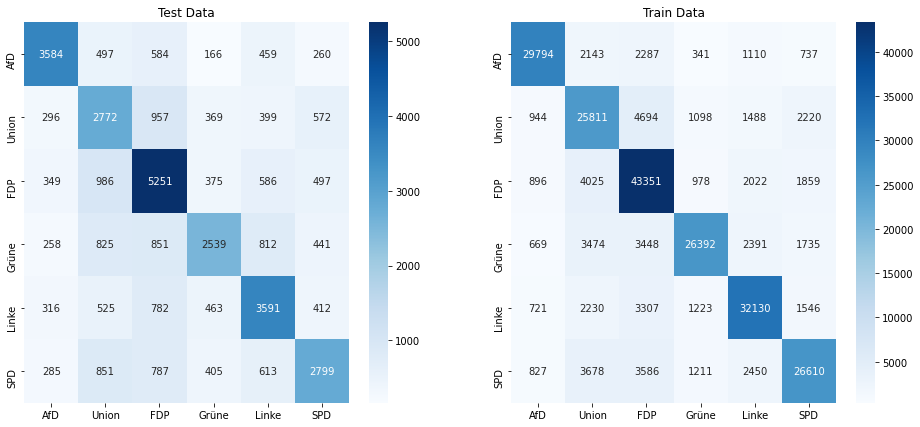

Party: 	 Test 	 Train
Afd:	 5550 	 36412
Union:	 5365 	 36255
FDP:	 8044 	 53131
Grüne:	 5726 	 38109
Linke:	 6089 	 41157
SPD:	 5740 	 38362

Acc:	 56.24% 75.62%


In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16,7))
# Block to evaluate training data
yhat_test = m5.model.predict(X_test)
yhat_test = np.argmax(yhat_test, axis=1)

y_label_test = np.argmax(y_test, axis=1)

mat = confusion_matrix(y_label_test, yhat_test)
df = pd.DataFrame(mat, index = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"],
                  columns = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"])
# ax1.figure(figsize = (7,5))
sn.heatmap(df, annot=True ,cmap='Blues', fmt='g', ax=axes[0]).set_title('Test Data');
# ax1.show()

# Block to evaluate test data
yhat_train = m5.model.predict(X_train)
yhat_train = np.argmax(yhat_train, axis=1)

y_label_train = np.argmax(y_train, axis=1)

mat = confusion_matrix(y_label_train, yhat_train)
df = pd.DataFrame(mat, index = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"],
                  columns = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"])
# ax2.figure(figsize = (7,5))
sn.heatmap(df, annot=True ,cmap='Blues', fmt='g', ax=axes[1]).set_title('Train Data');
plt.show()
print('Party: \t Test \t Train\nAfd:\t',sum(y_label_test == 0), "\t" , sum(y_label_train == 0))
print('Union:\t',sum(y_label_test == 1), "\t" , sum(y_label_train == 1))
print('FDP:\t',sum(y_label_test == 2), "\t" , sum(y_label_train == 2))
print('Grüne:\t',sum(y_label_test == 3), "\t" , sum(y_label_train == 3))
print('Linke:\t',sum(y_label_test == 4), "\t" , sum(y_label_train == 4))
print('SPD:\t',sum(y_label_test == 5), "\t" , sum(y_label_train == 5))
print('\nAcc:\t', "{:2.2f}%".format(accuracy_score(y_label_test,yhat_test)*100), "{:2.2f}%".format(accuracy_score(y_label_train,yhat_train)*100))

In [20]:
# Deep learning: 
class RnnModel5():

    def __init__(self, embedding_matrix, embedding_dim, max_len):
        
        inp1 = Input(shape=(max_len,))
        x = Embedding(embedding_matrix.shape[0], embedding_dim, weights=[embedding_matrix])(inp1)
        x = Bidirectional(LSTM(512, return_sequences=True))(x)
        x = Bidirectional(LSTM(256))(x)
        x = Dense(256, activation="relu")(x)
        x = Dropout(0.1)(x)
        x = Dense(256, activation="relu")(x)
        x = Dense(64, activation="relu")(x)
        x = Dense(6, activation="softmax")(x)    
        model = Model(inputs=inp1, outputs=x)
        model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=["accuracy"])
        self.model = model

In [21]:
m6 = RnnModel5(em_matrix, 300, 50)
h6 = m6.model.fit(X_train, y_train, epochs = 5, batch_size = 512, verbose = 1, validation_data=(X_val, y_val))

Epoch 1/5
476/476 [==============================] - 2057s 4s/step - loss: 0.3995 - accuracy: 0.3566 - val_loss: 0.3537 - val_accuracy: 0.4539
Epoch 2/5
476/476 [==============================] - 2023s 4s/step - loss: 0.3196 - accuracy: 0.5267 - val_loss: 0.3171 - val_accuracy: 0.5344
Epoch 3/5
476/476 [==============================] - 2076s 4s/step - loss: 0.2714 - accuracy: 0.6135 - val_loss: 0.3067 - val_accuracy: 0.5583
Epoch 4/5
476/476 [==============================] - 2008s 4s/step - loss: 0.2344 - accuracy: 0.6719 - val_loss: 0.3136 - val_accuracy: 0.5617
Epoch 5/5
476/476 [==============================] - 2118s 4s/step - loss: 0.2018 - accuracy: 0.7195 - val_loss: 0.3475 - val_accuracy: 0.5647


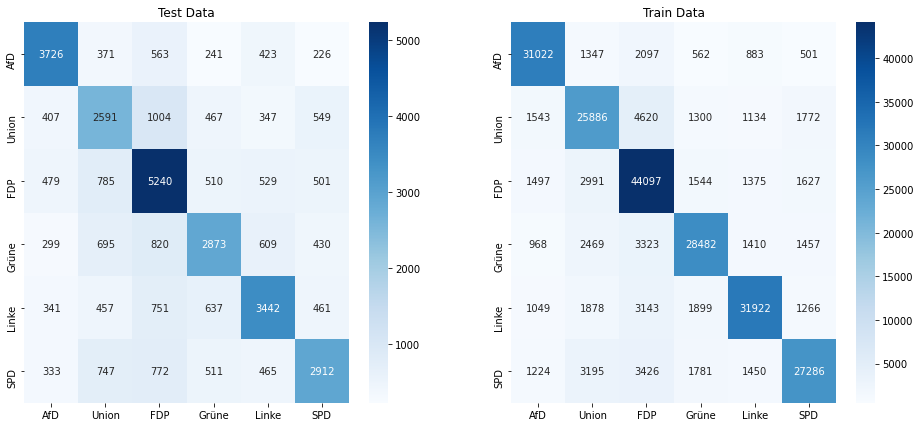

Party: 	 Test 	 Train
Afd:	 5550 	 36412
Union:	 5365 	 36255
FDP:	 8044 	 53131
Grüne:	 5726 	 38109
Linke:	 6089 	 41157
SPD:	 5740 	 38362

Acc:	 56.92% 77.52%


In [22]:
fig, axes = plt.subplots(1, 2, figsize=(16,7))
# Block to evaluate training data
yhat_test = m6.model.predict(X_test)
yhat_test = np.argmax(yhat_test, axis=1)

y_label_test = np.argmax(y_test, axis=1)

mat = confusion_matrix(y_label_test, yhat_test)
df = pd.DataFrame(mat, index = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"],
                  columns = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"])
# ax1.figure(figsize = (7,5))
sn.heatmap(df, annot=True ,cmap='Blues', fmt='g', ax=axes[0]).set_title('Test Data');
# ax1.show()

# Block to evaluate test data
yhat_train = m6.model.predict(X_train)
yhat_train = np.argmax(yhat_train, axis=1)

y_label_train = np.argmax(y_train, axis=1)

mat = confusion_matrix(y_label_train, yhat_train)
df = pd.DataFrame(mat, index = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"],
                  columns = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"])
# ax2.figure(figsize = (7,5))
sn.heatmap(df, annot=True ,cmap='Blues', fmt='g', ax=axes[1]).set_title('Train Data');
plt.show()
print('Party: \t Test \t Train\nAfd:\t',sum(y_label_test == 0), "\t" , sum(y_label_train == 0))
print('Union:\t',sum(y_label_test == 1), "\t" , sum(y_label_train == 1))
print('FDP:\t',sum(y_label_test == 2), "\t" , sum(y_label_train == 2))
print('Grüne:\t',sum(y_label_test == 3), "\t" , sum(y_label_train == 3))
print('Linke:\t',sum(y_label_test == 4), "\t" , sum(y_label_train == 4))
print('SPD:\t',sum(y_label_test == 5), "\t" , sum(y_label_train == 5))
print('\nAcc:\t', "{:2.2f}%".format(accuracy_score(y_label_test,yhat_test)*100), "{:2.2f}%".format(accuracy_score(y_label_train,yhat_train)*100))

In [24]:
S = "lemma_{mod}_ep{epo}_acc{acc}_valacc{valacc}".format(
        mod='Rnn5',
        epo=5,
        acc="{:2.2f}".format(h6.history["accuracy"][-1] * 100),
        valacc="{:2.2f}".format(h6.history["val_accuracy"][-1]*100),
    )
m6.model.save_weights('models/'+S+'/model_weights')

In [25]:
S = "lemma_{mod}_ep{epo}_acc{acc}_valacc{valacc}".format(
        mod='Rnn4',
        epo=5,
        acc="{:2.2f}".format(h5.history["accuracy"][-1] * 100),
        valacc="{:2.2f}".format(h5.history["val_accuracy"][-1]*100),
    )
m5.model.save_weights('models/'+S+'/model_weights')

In [26]:
S = "lemma_{mod}_ep{epo}_acc{acc}_valacc{valacc}".format(
        mod='Rnn2',
        epo=5,
        acc="{:2.2f}".format(h2.history["accuracy"][-1] * 100),
        valacc="{:2.2f}".format(h2.history["val_accuracy"][-1]*100),
    )
m2.model.save_weights('models/'+S+'/model_weights')